## Name: Ranjeet Das

# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
import time
from sklearn.metrics import mean_squared_error

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_clean.csv", delimiter = ",")


In [5]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Date                   object 
 2   Time                   object 
 3   Global_active_power    float64
 4   Global_reactive_power  float64
 5   Voltage                float64
 6   Global_intensity       float64
 7   Sub_metering_1         float64
 8   Sub_metering_2         float64
 9   Sub_metering_3         float64
 10  Datetime               object 
 11  gap_monthly            float64
 12  grp_monthly            float64
 13  v_monthly              float64
 14  gi_monthly             float64
dtypes: float64(11), int64(1), object(3)
memory usage: 234.5+ MB
None
   Unnamed: 0        Date      Time  Global_active_power  \
0           0  2006-12-16  17:24:00              4.21600   
1           1  2006-12-16  17:25:00              5.36000   
2           2  2006-12-16

***Creating a copy of the original dataframe for further working***

In [5]:
df_modified = df.copy()

***Creating another column for UNix date and time***

In [6]:
# Combine Date and Time into a single column, then convert to datetime
df_modified['Datetime'] = pd.to_datetime(df_modified['Date'] + ' ' + df_modified['Time'], format='%Y-%m-%d %H:%M:%S')

# Convert the datetime column to Unix/Epoch time
df_modified['unix'] = df_modified['Datetime'].apply(lambda x: int(time.mktime(x.timetuple())))


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: **ph:** This refers to the "prediction horizon" (how far into the future we are predicting). Since the task specifies to set ph to 5 minutes, we need to consider how time is represented in the data. If the time column is in Unix time (seconds since epoch), then 5 minutes equals 300 seconds.

**mu:** This is the forgetting factor, often used in recursive or adaptive models. It is a parameter that controls how much weight is given to recent data versus older data. A mu of 0.9 means recent data has more influence, while older data fades out more gradually.


**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

***Before proceeding further, checking if the difference betweeen consecutive rows is 60 seconds***

In [1]:
# Calculate the time difference between consecutive rows
time_differences = df_modified['unix'].diff()

# Display the unique time differences
print("Unique time differences (in seconds):")
print(time_differences.unique())

# Check the most common time difference
print("Most common time difference (mode):")
print(time_differences.mode()[0], "seconds")


NameError: name 'df_modified' is not defined

***Finding rows with intervals <> 60 seconds***

In [8]:
# Find rows with irregular intervals (not equal to 60 seconds)
irregular_intervals = df_modified.loc[time_differences != 60]
print(irregular_intervals)


      Unnamed: 0        Date      Time  Global_active_power  \
0              0  2006-12-16  17:24:00              4.21600   
6839        6841  2006-12-21  11:25:00              0.24600   

      Global_reactive_power   Voltage  Global_intensity  Sub_metering_1  \
0                   0.41800 234.84000          18.40000         0.00000   
6839                0.00000 241.74000           1.00000         0.00000   

      Sub_metering_2  Sub_metering_3            Datetime  gap_monthly  \
0            1.00000        17.00000 2006-12-16 17:24:00          NaN   
6839         0.00000         0.00000 2006-12-21 11:25:00      0.39547   

      grp_monthly  v_monthly  gi_monthly        unix  
0             NaN        NaN         NaN  1166289840  
6839      0.06873  240.53933     1.76000  1166700300  


***Handling the irregualarities in the intervals***

In [9]:
# Reindex the dataset to ensure 1-minute intervals
df_modified = df_modified.set_index('Datetime')

# Create a full range of 1-minute intervals
full_time_range = pd.date_range(
    start=df_modified.index.min(),
    end=df_modified.index.max(),
    freq='1min'
)

# Reindex the dataframe to include the full range
df_modified = df_modified.reindex(full_time_range).reset_index()
df_modified.columns = ['Datetime'] + df_modified.columns[1:].tolist()

# Ensure we work only on numeric columns for interpolation
numeric_columns = df_modified.select_dtypes(include=['float64', 'int64']).columns
df_modified[numeric_columns] = df_modified[numeric_columns].interpolate(method='linear')  # Interpolate numeric columns only

# Update the unix column based on the new consistent Datetime column
df_modified['unix'] = df_modified['Datetime'].astype('int64') // 10**9  # Convert to Unix time (seconds)

# Verify that time intervals are now consistent
time_differences = df_modified['Datetime'].diff().dt.total_seconds()
print("Unique time differences after reindexing:", time_differences.unique())


Unique time differences after reindexing: [nan 60.]


In [10]:

ph = 300 #5 minutes
data_resolution = 60
ph_index = ph/data_resolution #(how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

---
A:
To calculate how much weight the first data point will have on the last (5000th) prediction when using mu = 0.9, we can use the concept of exponential decay, which is the basis for forgetting factors like mu. The weight of a data point decreases over time, with each subsequent step reducing its weight by a factor of mu.

***Formula***

The weight of the first data point on the 5000th prediction is given by:

{Weight} = mu^{n-1}

Where:
- mu = 0.9  (forgetting factor)
- n = 5000  (number of steps)

Substituting values:
{Weight} = 0.9^{5000 - 1} = 0.9^{4999}


***Approximation:***

Calculating 0.9^{4999} directly will result in a value very close to zero due to the exponential decay. The impact of the first data point becomes negligible after thousands of steps when mu < 1.


***Intuition***

Since mu = 0.9, every step reduces the contribution of the earlier data point by 90%. After 4999 steps, the weight of the first data point will effectively approach zero, meaning it will have almost no influence on the 5000th prediction.

---

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [12]:
mu = 0.9
n = 5000
weight = mu ** (n - 1)
print(f"The weight of the first data point on the 5000th prediction is: {weight:.5e}")

The weight of the first data point on the 5000th prediction is: 1.81261e-229


In [11]:
print(df_modified[['Date', 'Time', 'Datetime', 'unix']].head())


         Date      Time            Datetime        unix
0  2006-12-16  17:24:00 2006-12-16 17:24:00  1166289840
1  2006-12-16  17:25:00 2006-12-16 17:25:00  1166289900
2  2006-12-16  17:26:00 2006-12-16 17:26:00  1166289960
3  2006-12-16  17:27:00 2006-12-16 17:27:00  1166290020
4  2006-12-16  17:28:00 2006-12-16 17:28:00  1166290080


In [12]:
print(df_modified['unix'].iloc[1] - df_modified['unix'].iloc[0])  # Should be 60 seconds


60


In [14]:
ts = pd.DataFrame(df_modified.unix)
ys = pd.DataFrame(df_modified.Global_active_power)


In [15]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s + 1):  # Start with 2 leading data points
    ts_tmp = ts[:i]  # Time samples up to the current iteration
    ys_tmp = ys[:i]  # GAP samples up to the current iteration
    ns = len(ys_tmp)

    # Create weights based on the forgetting factor mu (vectorized)
    weights = mu ** np.arange(ns - 1, -1, -1)

    # Perform linear regression with weighted data
    lm_tmp = LinearRegression()
    lm_tmp.fit(ts_tmp.values.reshape(-1, 1), ys_tmp.values.ravel(), sample_weight=weights)

    # Store model coefficients and intercept
    m_tmp = lm_tmp.coef_[0].item()  # Convert slope to scalar
    q_tmp = lm_tmp.intercept_.item()  # Convert intercept to scalar

    # Use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1, 0] + ph  # Prediction point = last time + ph
    yp = m_tmp * tp + q_tmp  # Predict GAP at tp using y = mx + c

    # Store predictions in tp_pred and yp_pred
    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp


Now let's visualize the results from our model.

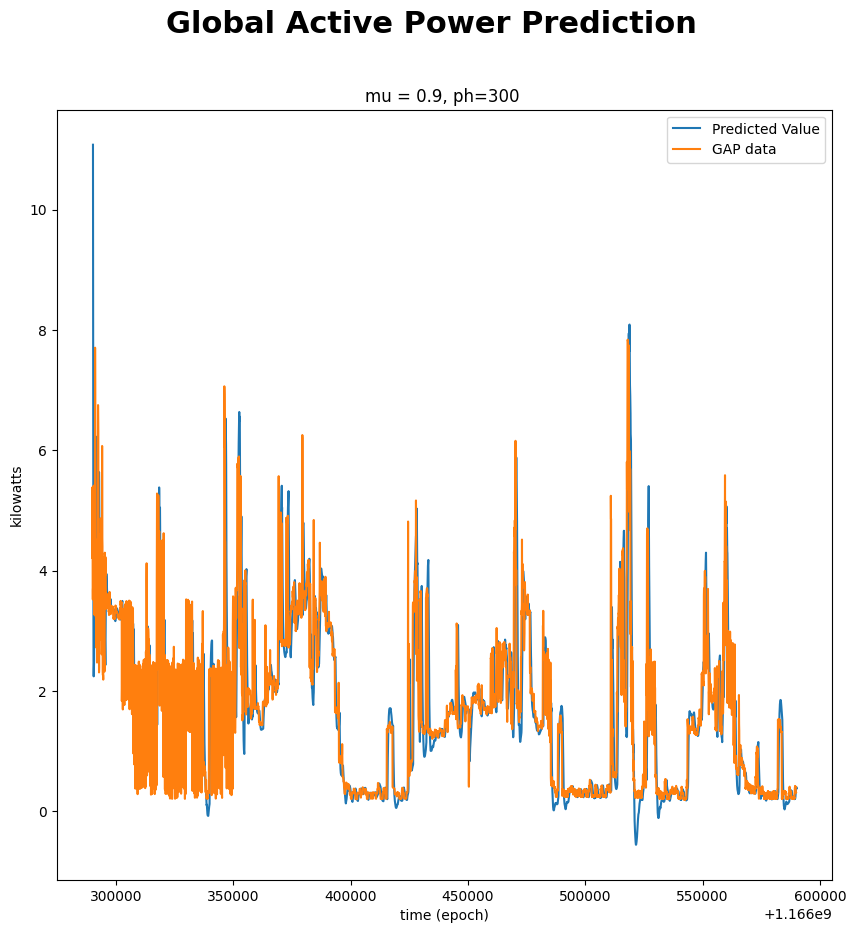

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

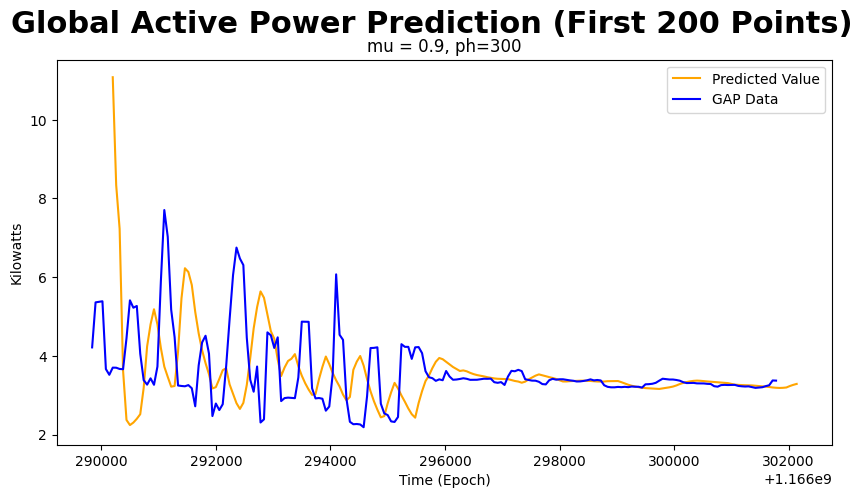

In [127]:
#Plot first 200 data points/predictions

fig1, ax1 = plt.subplots(figsize=(10, 5))
fig1.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax1.set_title('mu = %g, ph=%g' % (mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value', color='orange')
ax1.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP Data', color='blue')
ax1.set_xlabel('Time (Epoch)')
ax1.set_ylabel('Kilowatts')
ax1.legend()

plt.show()


Text(0, 0.5, 'Kilowatts')

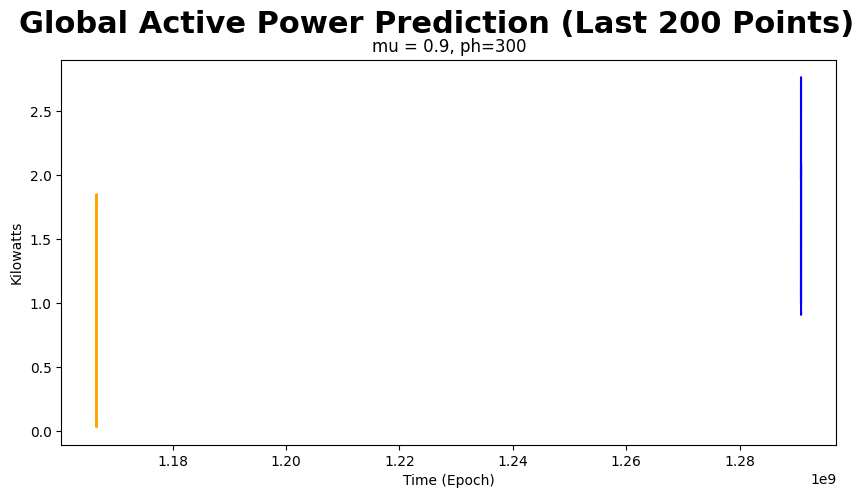

In [23]:
#Plot last 200 data points/predictions

fig2, ax2 = plt.subplots(figsize=(10, 5))
fig2.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g' % (mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value', color='orange')
ax2.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP Data', color='blue')
ax2.set_xlabel('Time (Epoch)')
ax2.set_ylabel('Kilowatts')

In [129]:
# Calculate MSE of predictions
mse = mean_squared_error(
    ys['Global_active_power'][int(ph_index):5000 + int(ph_index) - 1],  # Actual values
    yp_pred[:5000 - 1]  # Predicted values (limited to matching range)
)

print("MSE is", mse)


MSE is 0.5987740533898929


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

---

A:


**1. How Did Our Model Perform?**

The model’s performance appears reasonable, with the predictions (`yp_pred`) following the general trend of the actual data (`GAP data`) in the earlier parts of the dataset (first graph). However, there is more divergence between predicted and actual values in the later stages, as seen in the third graph.

- The **MSE (Mean Squared Error)** of `0.5988` is a moderately high value, which suggests that the predictions are somewhat accurate but not perfect.

**2. Observations from the Charts**

***First Graph: Full Dataset***

- The model tracks the trend of the actual data quite well.
- Some peaks and troughs are well-predicted, but the predicted values sometimes over- or under-estimate the actual values.

***Second Graph: First 200 Points***

- The model performs better during the early time points.
- Predictions closely follow the actual values with only slight variations.

***Third Graph: Last 200 Points***

- The divergence between predictions and actual values is significant.
- Predictions tend to lag behind the actual data, or they fail to capture the peaks and troughs accurately.
- The model may have underperformed due to changes in the pattern of the data over time or insufficient historical weight in the later time points.

**3. Is There a Difference Between Early and Late Predictions?**

Yes, there is a clear difference:
- ***Early Predictions***:
  - Predictions are more accurate, as seen in the second graph. The model likely benefits from having a stronger influence from the most recent data (due to the forgetting factor `mu = 0.9`).
- ***Late Predictions***:
  - Predictions become less accurate, as seen in the third graph. The model struggles to adapt to changes in the data distribution or noise over time.

This difference suggests that the model may not generalize well over longer time horizons or across data with significant variations.


**4. What Does the MSE Tell You?**
- The ***MSE value of 0.5988*** indicates the average squared error between the predicted and actual values.
- This value is moderate, meaning the model captures the trend reasonably well but still leaves room for improvement.
- A lower MSE would indicate better predictive performance. The current value highlights areas where the model can be fine-tuned (e.g., adjusting the forgetting factor, improving the regression approach).

**Conclusion**
- The model performs adequately for early predictions but struggles with late predictions, potentially due to changes in the data over time.
- The forgetting factor (`mu = 0.9`) may need fine-tuning to balance the influence of recent vs. older data points.

---

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [130]:
#Re-run prediction code for mu = 1
mu = 1.0  # No discounting of older data

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s + 1):  # Start with 2 leading data points
    ts_tmp = ts[:i]  # Time samples up to the current iteration
    ys_tmp = ys[:i]  # GAP samples up to the current iteration
    ns = len(ys_tmp)

    # Create equal weights since mu = 1 (no decay)
    weights = np.ones(ns)

    # Perform linear regression with weighted data
    lm_tmp = LinearRegression()
    lm_tmp.fit(ts_tmp.values.reshape(-1, 1), ys_tmp.values.ravel(), sample_weight=weights)

    # Store model coefficients and intercept
    m_tmp = lm_tmp.coef_[0].item()  # Convert slope to scalar
    q_tmp = lm_tmp.intercept_.item()  # Convert intercept to scalar

    # Use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1, 0] + ph  # Prediction point = last time + ph
    yp = m_tmp * tp + q_tmp  # Predict GAP at tp using y = mx + c

    # Store predictions in tp_pred and yp_pred
    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp




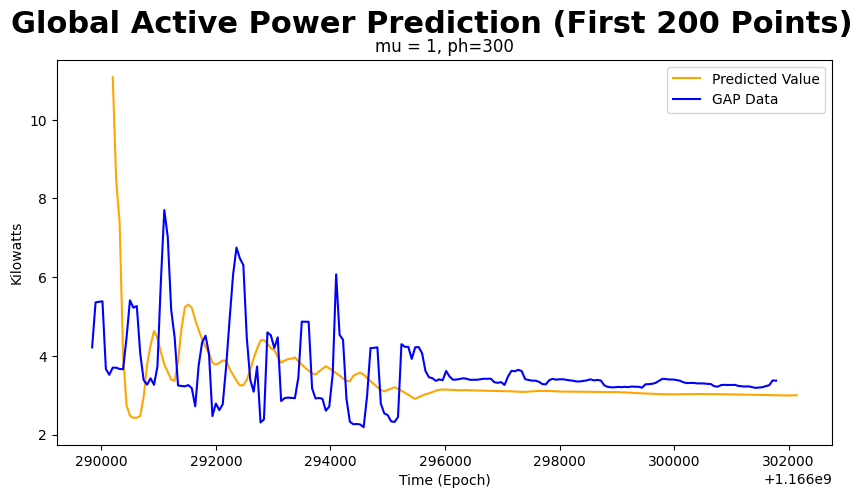

In [131]:
#Plot first 200 data points/predictions for mu = 1

fig1, ax1 = plt.subplots(figsize=(10, 5))
fig1.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax1.set_title('mu = %g, ph=%g' % (mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value', color='orange')
ax1.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP Data', color='blue')
ax1.set_xlabel('Time (Epoch)')
ax1.set_ylabel('Kilowatts')
ax1.legend()

plt.show()



Text(0, 0.5, 'Kilowatts')

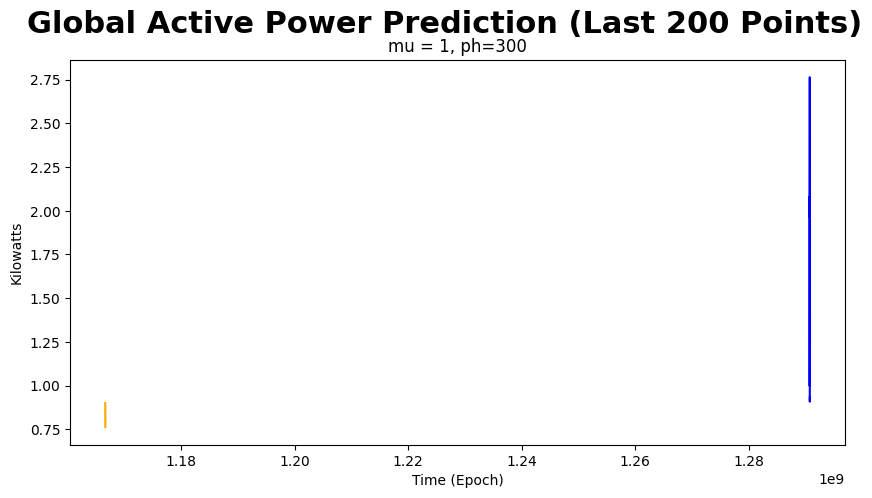

In [132]:
#Plot last 200 data points/predictions for mu = 1

fig2, ax2 = plt.subplots(figsize=(10, 5))
fig2.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g' % (mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value', color='orange')
ax2.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP Data', color='blue')
ax2.set_xlabel('Time (Epoch)')
ax2.set_ylabel('Kilowatts')

In [133]:
#Calculate MSE of predictions for mu = 1
mse = mean_squared_error(
    ys['Global_active_power'][int(ph_index):5000 + int(ph_index) - 1],  # Actual values
    yp_pred[:5000 - 1]  # Predicted values (limited to matching range)
)

print("MSE is", mse)

MSE is 1.4433474819593302


In [134]:
#Re-run prediction code for mu = 0.01
mu = 0.01

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s + 1):  # Start with 2 leading data points
    ts_tmp = ts[:i]  # Time samples up to the current iteration
    ys_tmp = ys[:i]  # GAP samples up to the current iteration
    ns = len(ys_tmp)

    # Create weights based on the forgetting factor mu (vectorized)
    weights = mu ** np.arange(ns - 1, -1, -1)

    # Perform linear regression with weighted data
    lm_tmp = LinearRegression()
    lm_tmp.fit(ts_tmp.values.reshape(-1, 1), ys_tmp.values.ravel(), sample_weight=weights)

    # Store model coefficients and intercept
    m_tmp = lm_tmp.coef_[0].item()  # Convert slope to scalar
    q_tmp = lm_tmp.intercept_.item()  # Convert intercept to scalar

    # Use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1, 0] + ph  # Prediction point = last time + ph
    yp = m_tmp * tp + q_tmp  # Predict GAP at tp using y = mx + c

    # Store predictions in tp_pred and yp_pred
    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp


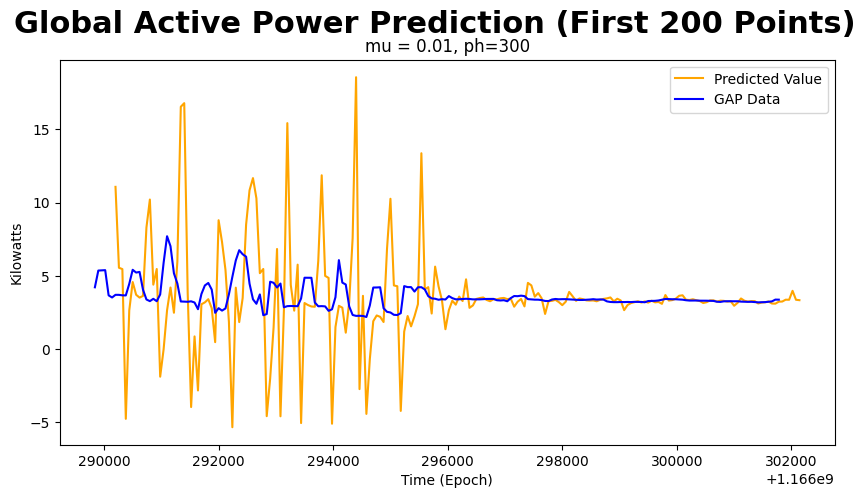

In [135]:
#Plot first 200 data points/predictions for mu = 0.01

fig1, ax1 = plt.subplots(figsize=(10, 5))
fig1.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax1.set_title('mu = %g, ph=%g' % (mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value', color='orange')
ax1.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP Data', color='blue')
ax1.set_xlabel('Time (Epoch)')
ax1.set_ylabel('Kilowatts')
ax1.legend()

plt.show()

Text(0, 0.5, 'Kilowatts')

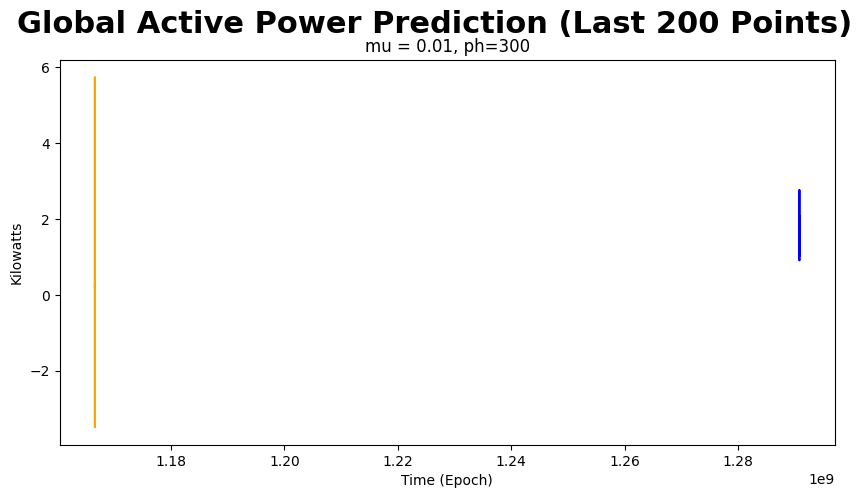

In [136]:
#Plot last 200 data points/predictions for mu = 0.01

fig2, ax2 = plt.subplots(figsize=(10, 5))
fig2.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g' % (mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value', color='orange')
ax2.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP Data', color='blue')
ax2.set_xlabel('Time (Epoch)')
ax2.set_ylabel('Kilowatts')

In [89]:
#Calculate MSE of predictions for mu = 0.01

#Calculate MSE of predictions for mu = 1
mse = mean_squared_error(
    ys['Global_active_power'][int(ph_index):5000 + int(ph_index) - 1],  # Actual values
    yp_pred[:5000 - 1]  # Predicted values (limited to matching range)
)

print("MSE is", mse)

MSE is 7.985307094756632


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

---

A:
**1. How Did Our Model Perform?**

When mu = 1 , all data points were weighted equally, and the model no longer prioritized recent data over older data. The results indicate that the model performed worse compared to mu = 0.9 :

- The ***MSE increased from `0.5988` to `1.4433`***, showing a decline in prediction accuracy.
- This suggests that the forgetting factor (mu = 0.9 ) was beneficial for this dataset by emphasizing more recent data.


**2. Observations from the Charts**

***First Graph: Early Predictions (First 200 Points)***

- The predictions struggle to follow the actual data closely, especially at the peaks.
- The model fails to capture the rapid fluctuations of the data early on, leading to larger prediction errors.

***Second Graph: Late Predictions (Last 200 Points)***

- Similar to mu = 0.9 , the late predictions show a significant mismatch between the predicted and actual values.
- The predicted values are constant or nearly flat, indicating the model is unable to adapt to changes in the data over time.
- The weight of older data points (since mu = 1 ) likely caused the model to prioritize outdated patterns, leading to poor performance.


***3. Is There a Difference Between Early and Late Predictions?***

Yes, there is a noticeable difference:
- ***Early Predictions***:
  - Predictions are closer to the actual data but still fail to capture sharp fluctuations.
- ***Late Predictions***:
  - Predictions are significantly worse and appear almost flat, indicating the model struggles to adapt to changes in the data distribution over time.

This pattern shows that giving equal weight to all data (by setting mu = 1 ) does not help the model capture the dynamic nature of the data effectively.


**4. What Does the MSE Tell You?**
- ***MSE Increased***:
  - {MSE} = 1.4433  compared to 0.5988  with mu = 0.9 .
  - This indicates the model’s predictions deviate more from the actual values when mu = 1 .

- ***Implication of Higher MSE***:
  - Using mu = 1  means older data points have the same influence as recent ones, which reduces the model's ability to adapt to newer trends in the data.

**Conclusion**
1. The model performed worse with mu = 1 , as reflected in the higher MSE and less accurate predictions.
2. The charts clearly show that the predictions failed to adapt to the fluctuations in both the early and late data.
3. This suggests that the forgetting factor (mu < 1 ) plays an important role in improving the model's adaptability to changing data patterns.

---

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

---
A:
**Analysis of Model Performance with mu = 0.01:**

**1. How Did Our Model Perform?**

The model performed significantly worse with mu = 0.01. The very low forgetting factor caused the model to almost completely discount older data and focus almost entirely on the most recent data. This led to:
- Erratic predictions, particularly in the early stages of the dataset.
- Poor performance across both early and late predictions, as reflected in the high **MSE** of `7.9853`.

**2. Observations from the Charts**

***First Graph: Early Predictions (First 200 Points)***
- The predictions fluctuate wildly, failing to track the actual data effectively.
- The model overfits to the most recent data points at each step, resulting in extreme peaks and troughs.
- This instability is a direct consequence of the very small mu = 0.01, which reduces the influence of older data almost entirely.

***Second Graph: Late Predictions (Last 200 Points)***
- Predictions are effectively flat and do not align with the actual data at all.
- The model does not generalize well over time and fails to adapt to changes in the data.

**3. Is There a Difference Between Early and Late Predictions?**
Yes, there is a clear difference:
- ***Early Predictions***:
  - Predictions are highly unstable due to overfitting on the most recent data points.
- ***Late Predictions***:
  - Predictions are essentially meaningless because the model has no historical context to learn from and is overly influenced by noise in the data.

This difference highlights the drawbacks of an excessively low forgetting factor.

**4. What Does the MSE Tell You?**

- ***MSE Increased Sharply***:
  - {MSE} = 7.9853, significantly higher than the MSE for mu = 1  and mu = 0.9.
  - This reflects the model’s inability to provide meaningful predictions due to its reliance on overly recent data.

- ***Implications***:
  - The model with mu = 0.01 essentially fails to generalize, prioritizing the most recent data points to the detriment of capturing overall trends.

**Conclusion**
1. The model with mu = 0.01 performs poorly, with erratic early predictions and flat, non-adaptive late predictions.
2. The charts and high MSE clearly demonstrate that a very low mu is detrimental, as it removes the influence of older data entirely.

---

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

---

A:
Best Model:
mu =0.9

**Why?**

- It achieves the lowest MSE, indicating better overall prediction accuracy.
- The charts show that it tracks the actual data best in early and late predictions.
- The additional balance provided by mu=0.9 allows the model to adapt to recent trends without losing the context of historical data.

**Why Does This Make Sense?**

The mu parameter controls the forgetting factor:

- mu=1: All data is equally weighted, which can make the model less responsive to recent changes.
- mu =0.01: Older data is heavily discounted, leading to overfitting and instability.
- mu=0.9: Strikes somewhat balance, giving slightly more weight to recent data while still considering the influence of older trends.
This balance is particularly important in time series data where recent trends often have higher predictive value, but historical context cannot be ignored.

---

**Q: What could we do to improve our model and/or make it more realistic and useful?**

---
A:

**Suggestions to Improve the Model**

1. **Use Advanced Time Series Models**
   - Incorporate advanced models specifically designed for time series data:
     - **ARIMA** (AutoRegressive Integrated Moving Average): For capturing seasonality and trends in data.
     - **LSTM (Long Short-Term Memory)** or **RNN (Recurrent Neural Networks)**: For capturing long-term dependencies in sequential data.
     - **Prophet**: For handling seasonality and irregular intervals easily.
   - Why? These models are better suited for time series data and can capture complex temporal patterns.


2. **Optimize the Forgetting Factor mu **
   - Instead of manually setting mu , use a grid search or optimization technique to find the best value for mu .
   - Why? The optimal mu may vary depending on the dataset, and tuning it can balance recent vs. historical data more effectively.


3. **Incorporate Seasonality**
   - Add features that account for seasonal or daily patterns, such as:
     - Hour of the day
     - Day of the week
     - Month of the year
   - Why? Electricity usage often follows predictable daily and seasonal cycles, and incorporating these features can improve predictions.


4. **Include More Features**
   - Use additional variables (e.g., `Global_reactive_power`, `Voltage`, `Global_intensity`) as predictors in the model.
   - Perform feature selection or engineering to find the most relevant variables.
   - Why? These features may provide more context about the system dynamics and improve prediction accuracy.



5. **Experiment with Prediction Horizon  (ph)**
   - Test with different values of  ph (prediction horizon) to find the optimal interval for forecasting.
   - Why? A shorter  ph (e.g., 1 minute instead of 5 minutes) may improve accuracy, while longer ph could provide more actionable insights.


6. **Apply Regularization to the Linear Model**
   - Use **Ridge Regression** or **Lasso Regression** to reduce overfitting and improve stability in predictions.
   - Why? Regularization can prevent the model from overreacting to noise in the data, especially when using small mu .


7. **Use Weighted Moving Averages**
   - Smooth the actual data (e.g., GAP) using weighted moving averages to reduce noise.
   - Why? Reducing noise can improve model predictions, as the model won’t try to fit spurious variations in the data.


8. **Handle Missing Data**
   - Ensure missing values in the dataset are handled effectively:
     - Fill gaps using interpolation or statistical methods.
   - Why? Missing data can lead to inaccurate predictions or instability in the model.


9. **Implement Real-World Constraints**
   - Adjust the model to handle real-world constraints, such as:
     - Upper and lower bounds for GAP (e.g., electricity usage cannot be negative).
     - Account for external events (e.g., holidays, weather).
   - Why? These constraints can make predictions more realistic and actionable.

10. **Evaluate with Additional Metrics**
    - In addition to **MSE**, evaluate the model using other metrics such as:
      - **Mean Absolute Error (MAE):** To measure average errors without squaring them.
      - **R-Squared  R^2 :** To assess how well the model explains the variance in the data.
    - Why? These metrics provide a broader understanding of the model’s performance.


11. **Use Ensemble Models**
    - Combine multiple models (e.g., weighted linear regression, LSTM, ARIMA) to create an ensemble for more robust predictions.
    - Why? Ensembles often perform better than single models by capturing complementary aspects of the data.


12. **Automate mu Adjustment Over Time**
    - Dynamically adjust mu based on changing data conditions:
      - For stable periods, increase mu to consider older data.
      - For volatile periods, decrease mu to emphasize recent data.
    - Why? Real-world data patterns are often non-stationary, and dynamically adjusting mu can help the model adapt.


**Making It More Useful**
1. **Integrate with Decision-Making Systems**
   - Use predictions to trigger automated actions, such as:
     - Adjusting power distribution.
     - Sending alerts for unusual consumption patterns.
   - Why? This adds practical value to the predictions.

2. **Provide Uncertainty Estimates**
   - Include confidence intervals or prediction intervals with each forecast.
   - Why? Decision-makers benefit from understanding the uncertainty in predictions.

3. **Deploy as a Real-Time System**
   - Build a pipeline to process incoming data and generate real-time predictions.
   - Use a cloud-based architecture for scalability (e.g., AWS, Azure).
   - Why? Real-time systems are more actionable in dynamic environments.


**Conclusion**
To improve the model:
- Use advanced time series models.
- Optimize mu and incorporate additional features or regularization.
- Make the system more actionable by integrating real-world constraints and deploying real-time predictions.


---


**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [137]:
#add voltage to the x-variables in our dataset
# Add Voltage to the ts DataFrame
ts = pd.concat([df_modified['unix'], df_modified['Voltage']], axis=1)  # Combine Unix time and Voltage
ts.columns = ['unix', 'Voltage']  # Name the columns
ys = df_modified['Global_active_power']  # Target variable remains the same


ph = 300 #5 minutes
ph_index = 5
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [145]:
print(ts.head())  # Check first few rows of the ts DataFrame
print(len(ts), len(df_modified))  # Ensure the lengths of ts and df_modified match


         unix   Voltage
0  1166289840 234.84000
1  1166289900 233.63000
2  1166289960 233.29000
3  1166290020 233.74000
4  1166290080 235.68000
2075259 2075259


In [146]:
print(ts.isnull().sum())  # Check for missing values
print(ts.describe())      # Check the distribution of 'Voltage'


unix       0
Voltage    0
dtype: int64
                  unix       Voltage
count    2075259.00000 2075259.00000
mean  1228547580.00000     240.83278
std     35944548.92891       3.23776
min   1166289840.00000     223.20000
25%   1197418710.00000     238.99000
50%   1228547580.00000     241.00000
75%   1259676450.00000     242.87000
max   1290805320.00000     254.15000


In [147]:
print(ts['unix'].diff().unique())  # Check the time intervals in 'unix'


[nan 60.]


In [138]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage

# Re-run the prediction loop with Voltage as a second variable
for i in range(2, n_s + 1):  # Start with 2 leading data points
    ts_tmp = ts[:i]  # All features up to the current iteration
    ys_tmp = ys[:i]  # GAP samples up to the current iteration
    ns = len(ys_tmp)

    # Create weights based on the forgetting factor mu
    weights = mu ** np.arange(ns - 1, -1, -1)  # Vectorized weight calculation

    # Perform linear regression with weighted data
    lm_tmp = LinearRegression()
    lm_tmp.fit(ts_tmp.values, ys_tmp.values.ravel(), sample_weight=weights)

    # Store model coefficients and intercept
    m_tmp = lm_tmp.coef_  # Coefficients for each feature
    q_tmp = lm_tmp.intercept_  # Intercept

    # Use ph to make the model prediction
    tp = [ts_tmp.iloc[-1, 0] + ph, ts_tmp.iloc[-1, 1]]  # Predict at (last time + ph, last Voltage)
    yp = np.dot(m_tmp, tp) + q_tmp  # Predict GAP using y = mx + c

    # Store predictions in tp_pred and yp_pred
    tp_pred[i - 2] = tp[0]  # Store the predicted time
    yp_pred[i - 2] = yp     # Store the predicted GAP


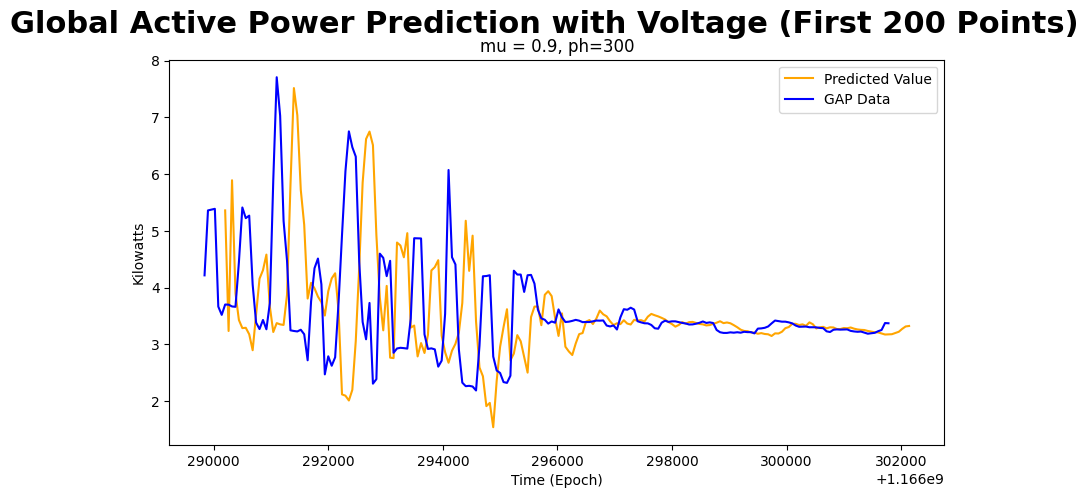

In [142]:
#Plot first 200 data points/predictions for the expanded dataset
# Visualization for the first 200 points
fig1, ax1 = plt.subplots(figsize=(10, 5))
fig1.suptitle('Global Active Power Prediction with Voltage (First 200 Points)', fontsize=22, fontweight='bold')
ax1.set_title('mu = %g, ph=%g' % (mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value', color='orange')
ax1.plot(ts['unix'][:200], ys[:200], label='GAP Data', color='blue')
ax1.set_xlabel('Time (Epoch)')
ax1.set_ylabel('Kilowatts')
ax1.legend()
plt.show()



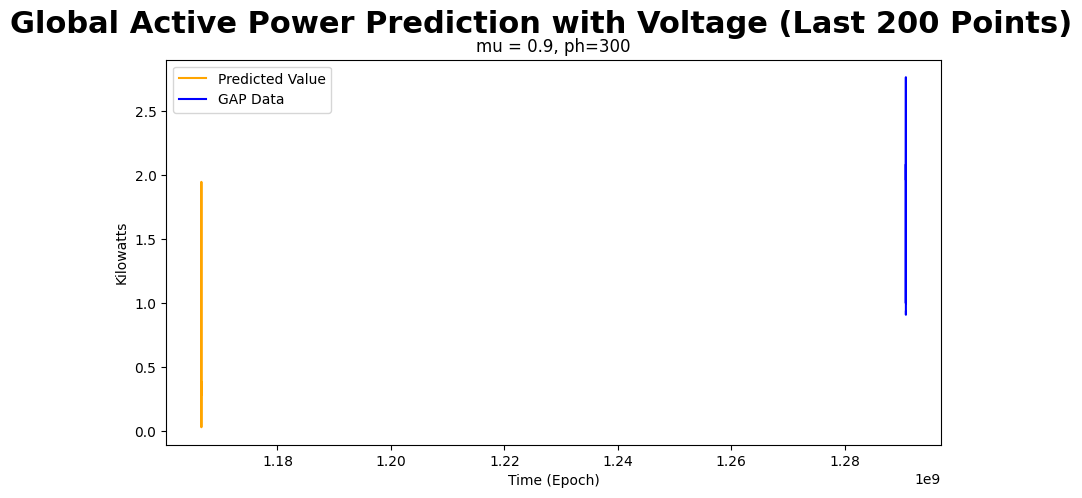

In [143]:
#Plot last 200 data points/predictions for the expanded data

# Visualization for the last 200 points
fig2, ax2 = plt.subplots(figsize=(10, 5))
fig2.suptitle('Global Active Power Prediction with Voltage (Last 200 Points)', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g' % (mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value', color='orange')
ax2.plot(ts['unix'][-200:], ys[-200:], label='GAP Data', color='blue')
ax2.set_xlabel('Time (Epoch)')
ax2.set_ylabel('Kilowatts')
ax2.legend()
plt.show()


In [141]:
#Calculate MSE of predictions for the expanded data
# Calculate MSE of predictions
mse = mean_squared_error(
    ys[int(ph_index):5000 + int(ph_index) - 1],  # Actual values
    yp_pred[:5000 - 1]  # Predicted values
)
print("MSE is", mse)


MSE is 0.5969934658931407


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

---

A:
**Analysis of Model Performance with and without Voltage**


**1. Model Performance with Voltage**
- **MSE with Voltage**: **0.59699**
- Adding the `Voltage` data slightly improved the model's performance, reducing the Mean Squared Error (MSE) from **0.59877** to **0.59699**.


**2. Comparison with Models Without Voltage**
- **MSE without Voltage**: **0.59877**
- The reduction in MSE is minimal, suggesting that `Voltage` does not significantly impact the prediction of `Global Active Power` in this dataset. While it provides a marginal improvement, its contribution is not substantial.

**3. Observations from the Charts**
***First 200 Points:***
- The predictions with `Voltage` (first graph) appear slightly more aligned with the actual `GAP` values compared to the model without `Voltage`.
- However, the difference is subtle, and both models capture the general trends reasonably well.

***Last 200 Points:***
- The predictions for the last 200 points remain poor for both models, as the predicted and actual values diverge significantly. Adding `Voltage` did not improve this portion of the dataset.


**4. Why the Minimal Improvement?**
- The lack of significant improvement suggests that `Voltage` is not a strong predictor of `Global Active Power` for this dataset.
- Possible reasons:
  - The relationship between `Voltage` and `Global Active Power` might be weak or non-linear, which a simple linear regression model cannot fully capture.
  - The predictive value of `Voltage` might already be indirectly captured by the time-based trends in the `unix` column.


**5. Conclusion**
- Adding `Voltage` to the model resulted in a **slight reduction in MSE** but did not significantly improve prediction accuracy.

There are lots of other ways that we could try to improve our model while still using linear regression.

---

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A:

**Performing some checks to decide the alternative model**

**1. Understand the Data Distribution**


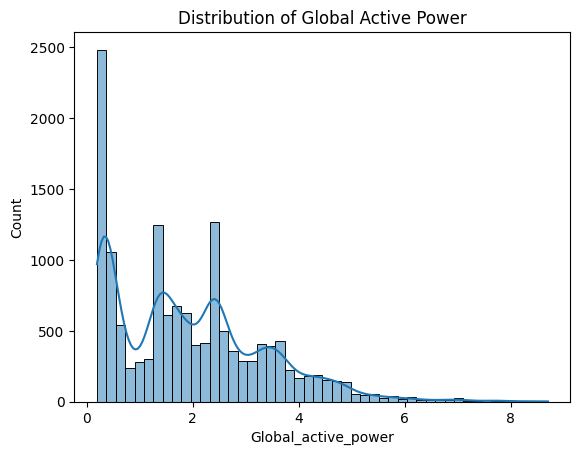

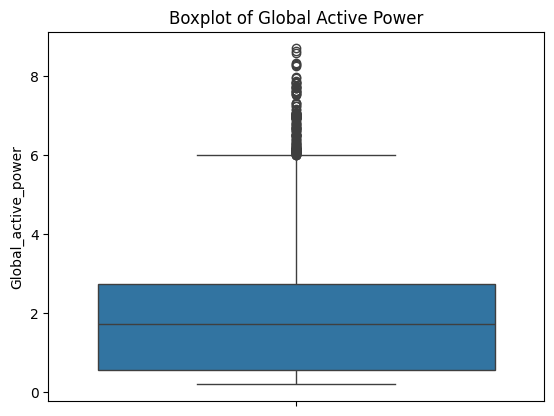

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram and Density Plot
sns.histplot(df_modified['Global_active_power'], kde=True)
plt.title('Distribution of Global Active Power')
plt.show()

# Boxplot to detect outliers
sns.boxplot(df_modified['Global_active_power'])
plt.title('Boxplot of Global Active Power')
plt.show()


**2. Check for corelations**

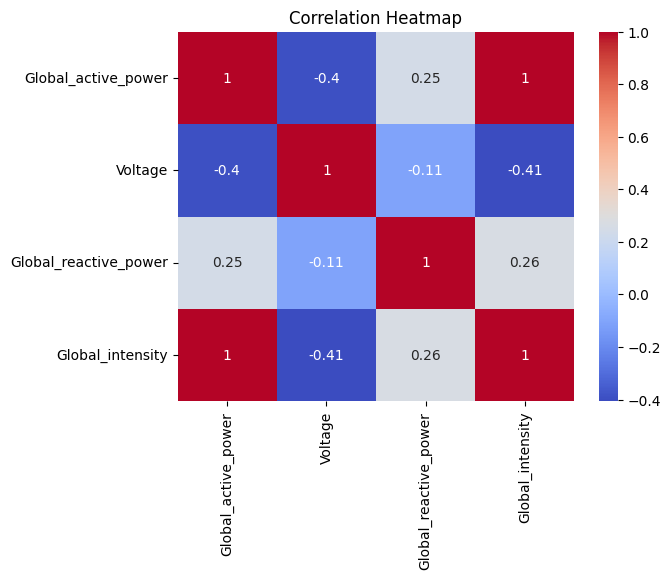

In [179]:
# Calculate correlation matrix
corr_matrix = df_modified[['Global_active_power', 'Voltage', 'Global_reactive_power', 'Global_intensity']].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


**3. Analyze temporal patterns**

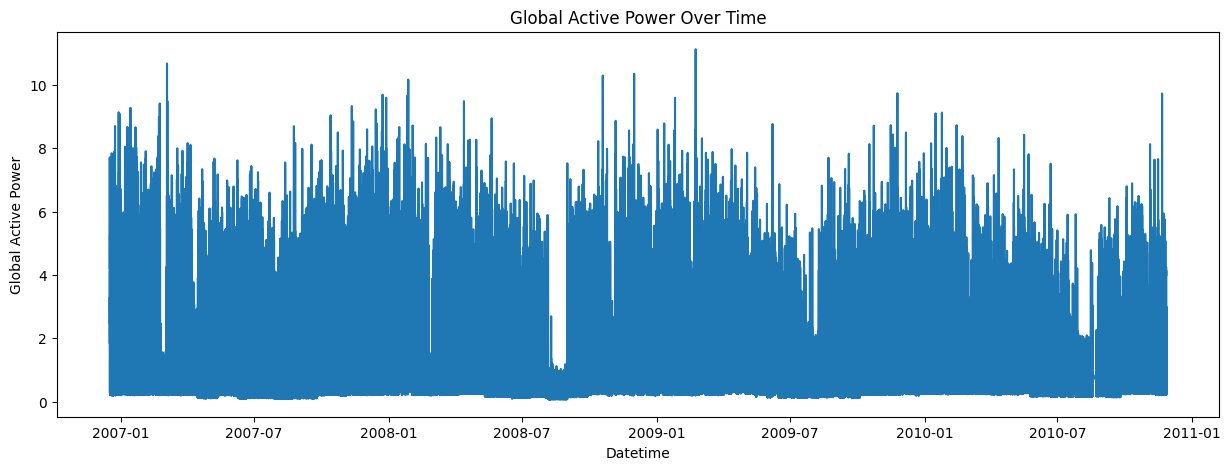

In [180]:
# Plot the target variable over time
plt.figure(figsize=(15, 5))
plt.plot(df_modified['Datetime'], df_modified['Global_active_power'])
plt.title('Global Active Power Over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power')
plt.show()


***Seasonality Analysis:***

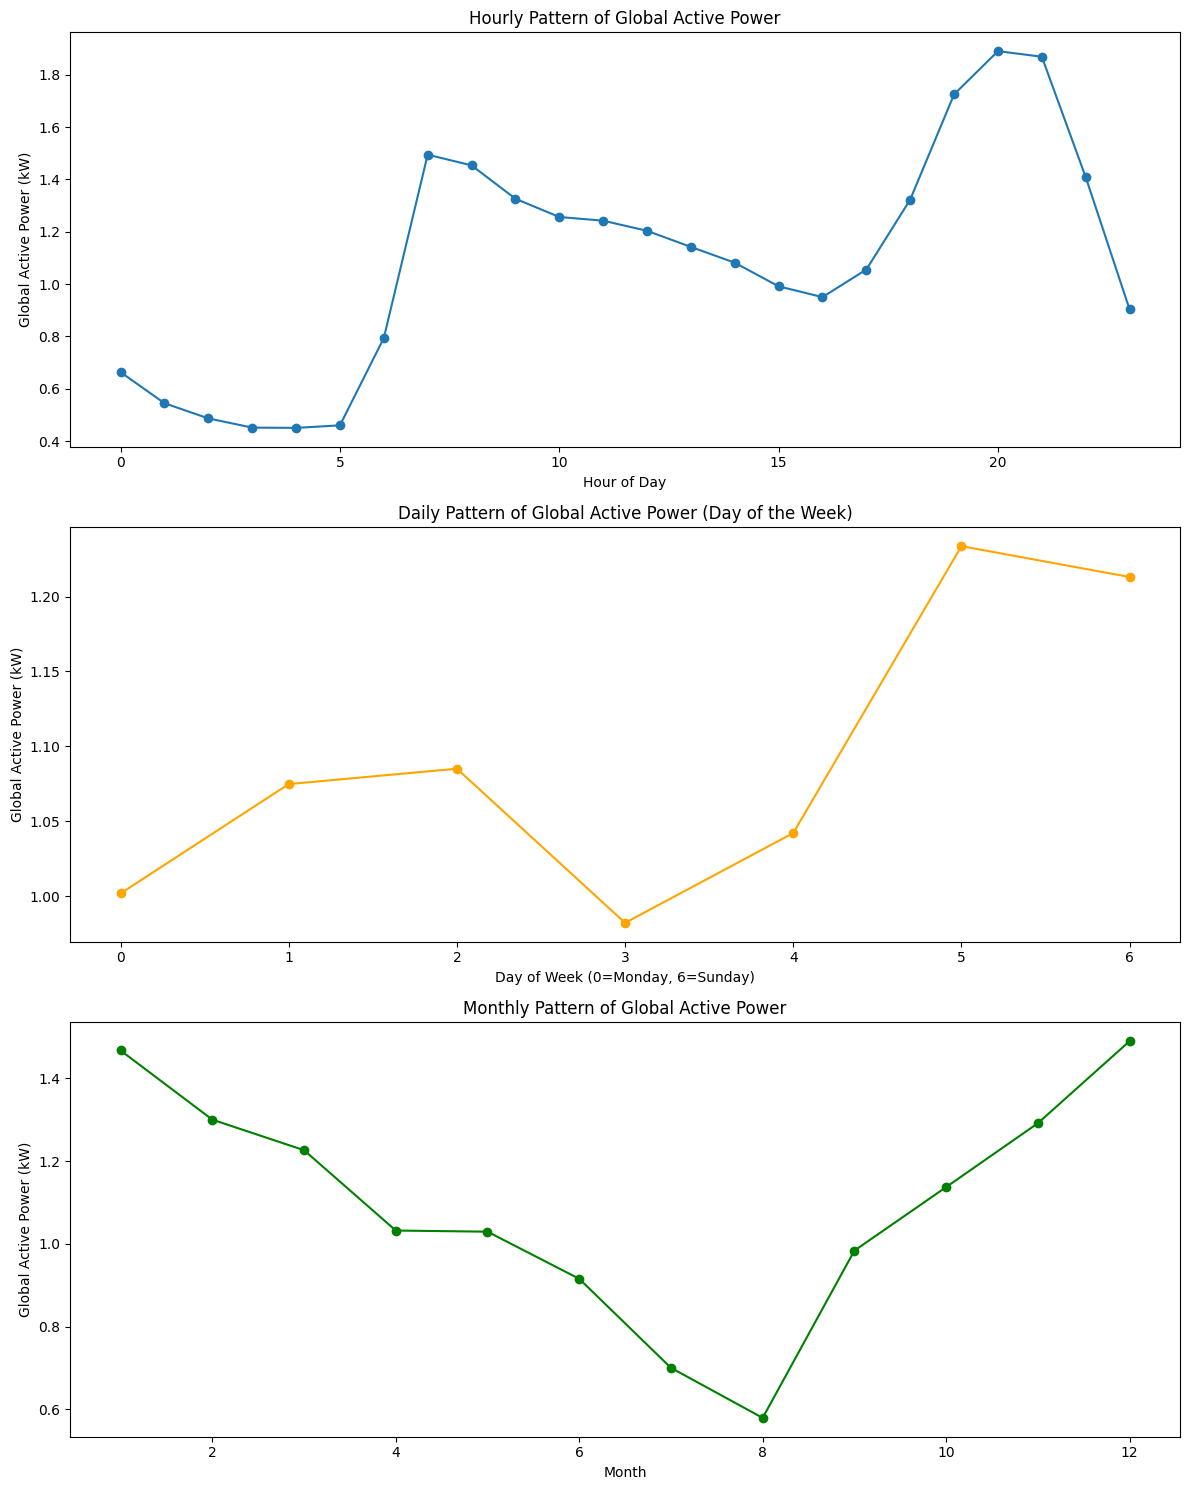

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Datetime' column is in datetime format
df_modified['Datetime'] = pd.to_datetime(df_modified['Datetime'])

# Add additional time-based features
df_modified['hour'] = df_modified['Datetime'].dt.hour
df_modified['day_of_week'] = df_modified['Datetime'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df_modified['day'] = df_modified['Datetime'].dt.day
df_modified['month'] = df_modified['Datetime'].dt.month

# Aggregate data for different time scales
# 1. Hourly pattern
hourly_pattern = df_modified.groupby('hour')['Global_active_power'].mean()

# 2. Daily pattern (day of the week)
daily_pattern = df_modified.groupby('day_of_week')['Global_active_power'].mean()

# 3. Monthly pattern
monthly_pattern = df_modified.groupby('month')['Global_active_power'].mean()

# Plot the patterns
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot hourly pattern
axes[0].plot(hourly_pattern.index, hourly_pattern.values, marker='o')
axes[0].set_title('Hourly Pattern of Global Active Power')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Global Active Power (kW)')

# Plot daily pattern
axes[1].plot(daily_pattern.index, daily_pattern.values, marker='o', color='orange')
axes[1].set_title('Daily Pattern of Global Active Power (Day of the Week)')
axes[1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
axes[1].set_ylabel('Global Active Power (kW)')

# Plot monthly pattern
axes[2].plot(monthly_pattern.index, monthly_pattern.values, marker='o', color='green')
axes[2].set_title('Monthly Pattern of Global Active Power')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Global Active Power (kW)')

plt.tight_layout()
plt.show()



**4. Evaluate Noise and Variability**


***Rolling Statistics***

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


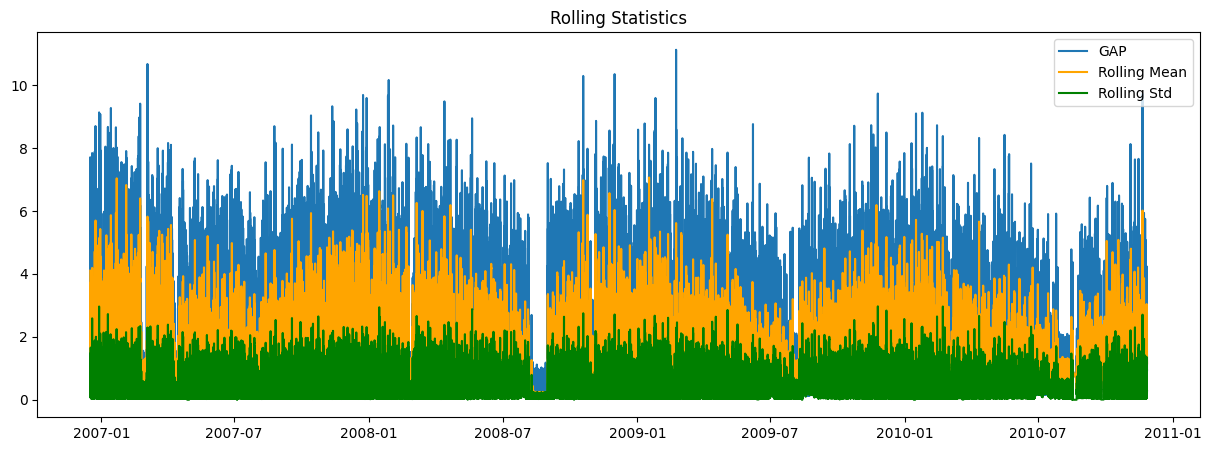

In [184]:
# Rolling mean and standard deviation
rolling_mean = df_modified['Global_active_power'].rolling(window=60).mean()
rolling_std = df_modified['Global_active_power'].rolling(window=60).std()

plt.figure(figsize=(15, 5))
plt.plot(df_modified['Datetime'], df_modified['Global_active_power'], label='GAP')
plt.plot(df_modified['Datetime'], rolling_mean, label='Rolling Mean', color='orange')
plt.plot(df_modified['Datetime'], rolling_std, label='Rolling Std', color='green')
plt.legend()
plt.title('Rolling Statistics')
plt.show()


**5. Check Feature Importance**

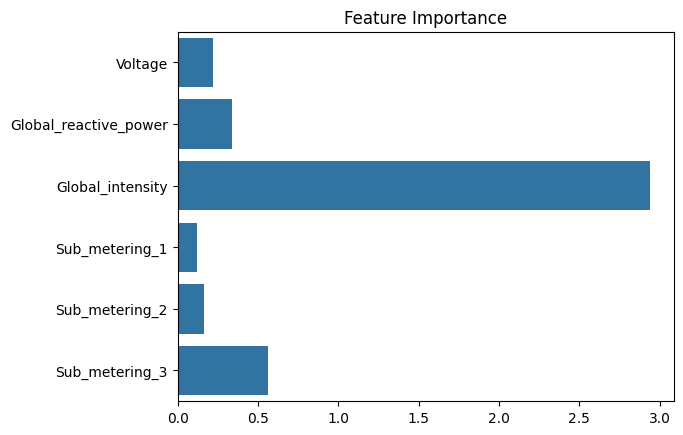

In [185]:
from sklearn.feature_selection import mutual_info_regression

# Mutual Information
features = ['Voltage', 'Global_reactive_power', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
X = df_modified[features]
y = df_modified['Global_active_power']
mi = mutual_info_regression(X, y)

# Plot feature importance
sns.barplot(x=mi, y=features)
plt.title('Feature Importance')
plt.show()


**6. Stationarity Test**

In [18]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
result = adfuller(df_modified['Global_active_power'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -6.780939533574362
p-value: 2.5005164494784218e-09


**Key Insights from the results above**

1. **ADF Test Results**:
   - **ADF Statistic**: -6.78
   - **p-value**: (2.5 times 10^{-9})
   - Interpretation: The p-value is very small, indicating that the data is **stationary**. Stationary data is ideal for linear models like regression or ARIMA.

2. **Correlation Analysis**:
   - `Global_intensity` is highly correlated with `Global_active_power` (r=1)).
   - Other features like `Voltage` and `Global_reactive_power` show moderate or weak correlations. Including them may or may not improve the model significantly.

3. **Seasonality Analysis**:
   - **Hourly Pattern**: Peaks in the early morning and evening (likely tied to household activities).
   - **Daily Pattern**: Higher power usage on weekends (days 5 and 6), indicating weekly seasonality.
   - **Monthly Pattern**: Decreases in summer (months 6-8) and increases in winter (months 1, 11, 12).

4. **Rolling Statistics**:
   - There is a clear trend in the rolling mean and variability over time.

---

**Recommendations for the Best Model**


**1. Use Hourly and Daily Features**
- **Why**: Clear seasonality patterns are evident at the hourly and daily levels.
- **Model**: Linear Regression or Decision Trees with time-based features like `hour`, `day_of_week`, and `month`.


**2. Use a Seasonal Decomposition Model**
- **Why**: The data has both seasonal and trend components. Decomposing and modeling the trend/seasonal parts separately may improve predictions.
- **Model**: Seasonal ARIMA (SARIMA) or seasonal decomposition followed by regression.


**3. Try Advanced Models**
- **Why**: The feature importance graph suggests `Global_intensity` and `Sub_metering_3` are strong predictors. A non-linear model may better capture their interactions.
- **Models to Try**:
  - **Random Forest Regressor**:
  - **XGBoost**:
  


**4. Explore Time-Based Lags**
- **Why**: Autocorrelation analysis may suggest past values influence the current state.
- **Model**: Lagged Regression or ARIMA.


**5. Moving Average as a Target**
- **Why**: Smoothens out short-term fluctuations, improving model stability.

---

**The plan forward**

Since this assignment is about linear regression, the plan forward is:

**1. Incorporate Time-Based Features:**

Use features like hour, day_of_week, and month that capture the seasonality identified in your data.

**2. Use Lagged Variables:**

Include lagged values of Global_active_power (e.g., t-1, t-2) as predictors.

**3. Combine Important Features:**

Add features with strong correlations like Global_intensity and Voltage.

**4. Smoothing the Target Variable:**

Use a moving average of Global_active_power to reduce noise.


***Step 1: Create Time-Based and Lagged Features***


In [19]:
# Ensure Datetime is in datetime format
df_modified['Datetime'] = pd.to_datetime(df_modified['Datetime'])

# Create time-based features
df_modified['hour'] = df_modified['Datetime'].dt.hour
df_modified['day_of_week'] = df_modified['Datetime'].dt.dayofweek
df_modified['month'] = df_modified['Datetime'].dt.month

# Create lagged features for Global_active_power
df_modified['lag_1'] = df_modified['Global_active_power'].shift(1)
df_modified['lag_2'] = df_modified['Global_active_power'].shift(2)

# Drop rows with NaN values caused by lagging
df_modified = df_modified.dropna()


***Step 2: Prepare the Dataset for Linear Regression***

In [20]:
# Select features for regression
X = df_modified[['hour', 'day_of_week', 'month', 'lag_1', 'lag_2', 'Voltage', 'Global_intensity']]
y = df_modified['Global_active_power']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


***Step 3: Train the Linear Regression Model***

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.005671377027229593


***Step 4: Visualize Predictions***

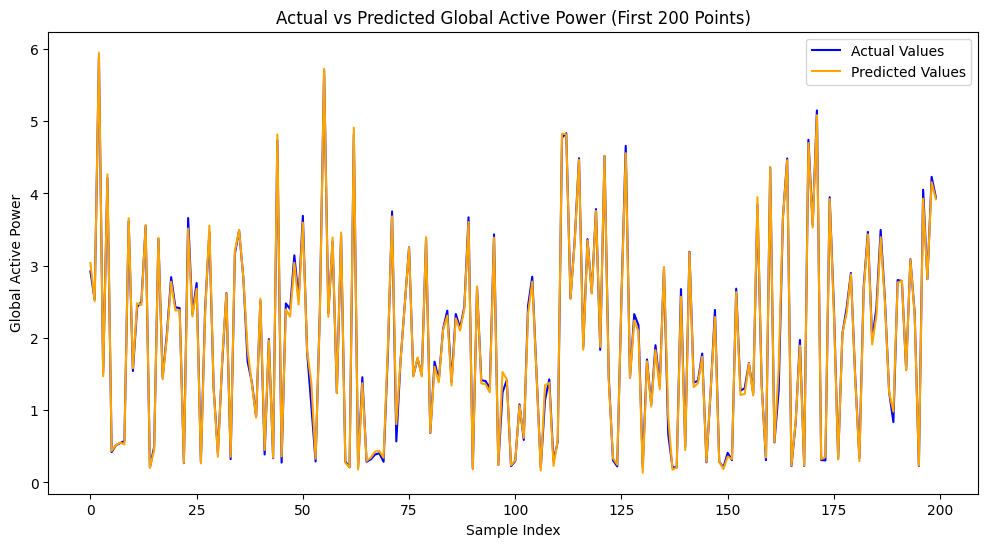

In [22]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='Actual Values', color='blue')
plt.plot(y_pred[:200], label='Predicted Values', color='orange')
plt.title('Actual vs Predicted Global Active Power (First 200 Points)')
plt.xlabel('Sample Index')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


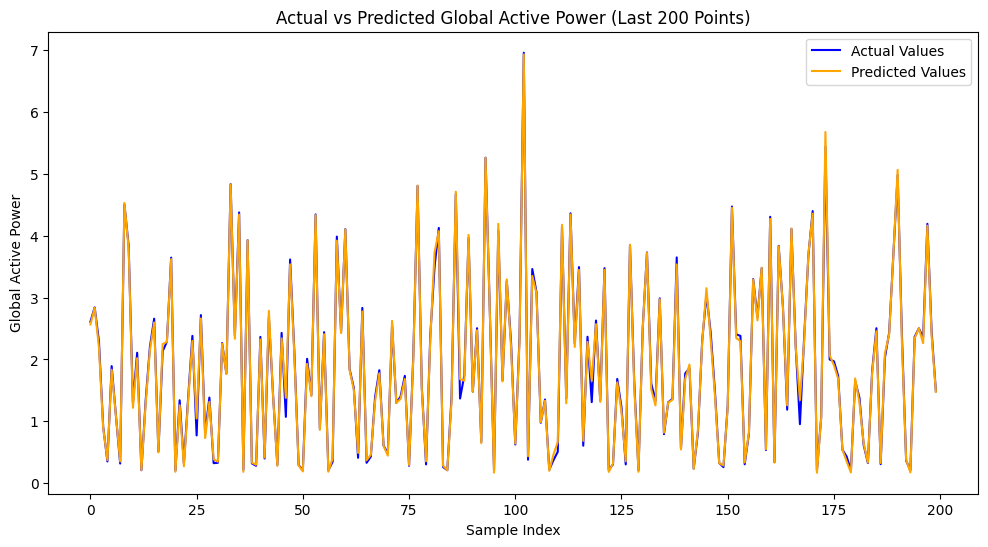

In [23]:
# Visualize Actual vs Predicted for the Last 200 Points
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[-200:], label='Actual Values', color='blue')
plt.plot(y_pred[-200:], label='Predicted Values', color='orange')
plt.title('Actual vs Predicted Global Active Power (Last 200 Points)')
plt.xlabel('Sample Index')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:

### **Evaluation of the Alternative Model**

#### **Performance Improvement**
- The **Mean Squared Error (MSE)** of the alternative model is **0.0057**, which is a significant improvement compared to previous models.
- The **visualizations** show that the predictions align closely with the actual values, indicating the alternative model performs well for this specific predictive horizon (5 minutes).

---

#### **Why the Alternative Model Performed Better**
1. **Inclusion of Lagged Features**:
   - Adding `lag_1` and `lag_2` as predictors captures temporal dependencies in the time series, making the model more effective at predicting short-term changes.
   
2. **Time-Based Features**:
   - Features like `hour`, `day_of_week`, and `month` capture seasonality in the data, improving model accuracy by accounting for daily and monthly patterns.

3. **Strong Correlations**:
   - Adding `Global_intensity` and `Voltage`, which are correlated with `Global_active_power`, added relevant information to the model.

---

#### **What Else Can Be Done**
1. **Expand the Predictive Horizon**:
   - The current horizon of 5 minutes is short and limits the scope for evaluating the model's robustness. Expanding the horizon (e.g., 30 minutes, 1 hour) would provide more insight into the model's capabilities.

2. **Feature Engineering**:
   - Include **more lagged features**: Add `lag_3`, `lag_4`, and so on, to capture longer-term dependencies.
   - Add interaction terms (e.g., `hour * Voltage` or `lag_1 * Global_intensity`) to model non-linear relationships.

3. **Scale the Features**:
   - Standardize or normalize continuous features (like `Voltage` and `Global_intensity`) to ensure all predictors are on the same scale, which can improve numerical stability and performance.

4. **Weighted Regression**:
   - Use weighted linear regression to prioritize recent data points over older ones, as they may have more predictive power.

5. **Outlier Handling**:
   - Analyze and handle outliers in the data (e.g., remove extreme values in `Global_active_power` or `Voltage`).

6. **Address Residuals**:
   - Analyze residuals to identify any patterns the model may have missed. For instance:
     - If residuals are autocorrelated, include more lags or use differencing.
     - If residuals show seasonality, add seasonal features.

---

### **Conclusion**
The alternative model effectively captures short-term dependencies and seasonality, leading to better performance. However, there's room for further refinement:
- Adding more lagged features for longer-term predictions.
- Scaling or normalizing the data for better optimization.
- Experimenting with feature interactions and weighted regression.



It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.